In [26]:
#import imgaug.augmenters as iaa
import numpy as np
import random
import time
import cv2
import cupy as cp
import math
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from scipy.ndimage import zoom as scizoom
from cupyimg.skimage.transform import resize

In [71]:
def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def getOptimalKernelWidth1D(radius, sigma):
    return radius * 2 + 1

def gauss_function(x, mean, sigma):
    return (cp.exp(- x**2 / (2 * (sigma**2)))) / (cp.sqrt(2 * cp.pi) * sigma)

def getMotionBlurKernel_cupy(width, sigma):
    k = gauss_function(cp.arange(width), 0, sigma)
    Z = cp.sum(k)
    return k/Z

def shift_cupy(image, dx, dy):
    if(dx < 0):
        shifted = cp.roll(image, shift=image.shape[1]+dx, axis=1)
        shifted[:,dx:] = shifted[:,dx-1:dx]
    elif(dx > 0):
        shifted = cp.roll(image, shift=dx, axis=1)
        shifted[:,:dx] = shifted[:,dx:dx+1]
    else:
        shifted = image

    if(dy < 0):
        shifted = cp.roll(shifted, shift=image.shape[0]+dy, axis=0)
        shifted[dy:,:] = shifted[dy-1:dy,:]
    elif(dy > 0):
        shifted = cp.roll(shifted, shift=dy, axis=0)
        shifted[:dy,:] = shifted[dy:dy+1,:]
    return shifted

def rgb2gray_cupy(rgb):
    return cp.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def plasma_fractal_cupy(mapsize = 256, wibbledecay=3):
    assert (mapsize & (mapsize - 1) == 0)
    maparray = cp.empty((mapsize, mapsize), dtype=cp.float_)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100
    
    def wibbledmean(array):
        return array / 4 + wibble * cp.random.uniform(-wibble, wibble,
                                                      array.shape)
    def fillsquares():
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + cp.roll(cornerref, shift=-1, axis=0)
        squareaccum += cp.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(squareaccum)
        
    def filldiamonds():
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + cp.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + cp.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(ltsum)
        tdrsum = drgrid + cp.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + cp.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize, 0:mapsize:stepsize] = wibbledmean(ttsum)
        
    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / maparray.max()

def clipped_zoom_cupy(img, zoom_factor):
    # clipping along the width dimension:
    ch0 = int(cp.ceil(img.shape[0] / float(zoom_factor)))
    top0 = (img.shape[0] - ch0) // 2

    # clipping along the height dimension:
    ch1 = int(cp.ceil(img.shape[1] / float(zoom_factor)))
    top1 = (img.shape[1] - ch1) // 2

    img = cp.array(scizoom(cp.asnumpy(img[top0:top0 + ch0, top1:top1 + ch1]),
                  (zoom_factor, zoom_factor, 1), order=1))
    
    return img
    
def _motion_blur_cupy(x, radius, sigma, angle):
    width = getOptimalKernelWidth1D(radius, sigma)
    kernel = getMotionBlurKernel_cupy(width, sigma)
    point = (width * cp.sin(cp.deg2rad(angle)), width * cp.cos(cp.deg2rad(angle)))
    hypot = math.hypot(point[0], point[1])

    blurred = cp.zeros_like(x, dtype=np.float32)
    for i in range(width):
        dy = -math.ceil(((i*point[0]) / hypot) - 0.5)
        dx = -math.ceil(((i*point[1]) / hypot) - 0.5)
        if (cp.abs(dy) >= x.shape[0] or cp.abs(dx) >= x.shape[1]):
            # simulated motion exceeded image borders
            break
        shifted = shift_cupy(x, dx, dy)
        blurred = blurred + kernel[i] * shifted
    return blurred

In [72]:
def fog_cupy(x, severity=1):
    c = [(1.5, 2), (2., 2), (2.5, 1.7), (2.5, 1.5), (3., 1.4)][severity - 1]

    shape = cp.array(x).shape
    max_side = cp.max(shape)
    map_size = next_power_of_2(int(max_side))

    x = cp.array(x) / 255.
    max_val = x.max()

    x_shape = cp.array(x).shape
    if len(x_shape) < 3 or x_shape[2] < 3:
        x += c[0] * plasma_fractal_cupy(mapsize=map_size, wibbledecay=c[1])[
                    :shape[0], :shape[1]]
    else:
        x += c[0] * \
             plasma_fractal_cupy(mapsize=map_size, wibbledecay=c[1])[:shape[0],
             :shape[1]][..., cp.newaxis]
    return cp.clip(x * max_val / (max_val + c[0]), 0, 1) * 255

def frost_cupy(x, severity=1):
    c = [(1, 0.4),
         (0.8, 0.6),
         (0.7, 0.7),
         (0.65, 0.7),
         (0.6, 0.75)][severity - 1]

    idx = np.random.randint(5)
    filename = [resource_filename(__name__, './frost/frost1.png'),
                resource_filename(__name__, './frost/frost2.png'),
                resource_filename(__name__, './frost/frost3.png'),
                resource_filename(__name__, './frost/frost4.jpg'),
                resource_filename(__name__, './frost/frost5.jpg'),
                resource_filename(__name__, './frost/frost6.jpg')][idx]
    frost = cv2.imread(filename)
    print(frost)
    frost_shape = frost.shape
    x_shape = cp.array(x).shape

    # resize the frost image so it fits to the image dimensions
    scaling_factor = 1
    if frost_shape[0] >= x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = 1
    elif frost_shape[0] < x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = x_shape[0] / frost_shape[0]
    elif frost_shape[0] >= x_shape[0] and frost_shape[1] < x_shape[1]:
        scaling_factor = x_shape[1] / frost_shape[1]
    elif frost_shape[0] < x_shape[0] and frost_shape[1] < x_shape[
        1]:  # If both dims are too small, pick the bigger scaling factor
        scaling_factor_0 = x_shape[0] / frost_shape[0]
        scaling_factor_1 = x_shape[1] / frost_shape[1]
        scaling_factor = cp.maximum(scaling_factor_0, scaling_factor_1)

    scaling_factor *= 1.1
    new_shape = (int(cp.ceil(frost_shape[1] * scaling_factor)),
                 int(cp.ceil(frost_shape[0] * scaling_factor)))
    frost_rescaled = cp.array(cv2.resize(frost, dsize=new_shape,
                                interpolation=cv2.INTER_CUBIC))
    print(frost_rescaled)

    # randomly crop
    x_start, y_start = np.random.randint(0, frost_rescaled.shape[0] - x_shape[
        0]), np.random.randint(0, frost_rescaled.shape[1] - x_shape[1])

    if len(x_shape) < 3 or x_shape[2] < 3:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]]
        frost_rescaled = rgb2gray_cupy(frost_rescaled)
    else:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]][..., [2, 1, 0]]
        
    return np.clip(c[0] * cp.array(x) + c[1] * frost_rescaled, 0, 255)

def snow_cupy(x, severity=1):
    c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
         (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
         (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
         (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
         (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]
    
    gray_x = cp.array(cv2.cvtColor(x,cv2.COLOR_RGB2GRAY))
    x = cp.array(x, dtype=np.float32) / 255.
    snow_layer = cp.random.normal(size=x.shape[:2], loc=c[0],
                                  scale=c[1])  # [:2] for monochrome

    snow_layer = clipped_zoom_cupy(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = cp.clip(snow_layer.squeeze(), 0, 1)


    snow_layer = _motion_blur_cupy(snow_layer, radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    # The snow layer is rounded and cropped to the img dims
    snow_layer = cp.round_(snow_layer * 255).astype(cp.uint8) / 255.
    snow_layer = snow_layer[..., cp.newaxis]
    snow_layer = snow_layer[:x.shape[0], :x.shape[1], :]

    if len(x.shape) < 3 or x.shape[2] < 3:
        x = c[6] * x + (1 - c[6]) * cp.maximum(x, x.reshape(x.shape[0],
                                                            x.shape[
                                                                1]) * 1.5 + 0.5)
        snow_layer = snow_layer.squeeze(-1)
    else:
        x = c[6] * x + (1 - c[6]) * np.maximum(x, gray_x.reshape(
            x.shape[0], x.shape[1], 1) * 1.5 + 0.5)
    try:
        return cp.clip(x + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255
    except ValueError:
        print('ValueError for Snow, Exception handling')
        x[:snow_layer.shape[0], :snow_layer.shape[1]] += snow_layer + np.rot90(
            snow_layer, k=2)
        return cp.clip(x, 0, 1) * 255
    
def zoom_blur_cupy(x, severity=1):
    c = [np.arange(1, 1.11, 0.01),
         np.arange(1, 1.16, 0.01),
         np.arange(1, 1.21, 0.02),
         np.arange(1, 1.26, 0.02),
         np.arange(1, 1.31, 0.03)][severity - 1]

    x = (cp.array(x) / 255.).astype(np.float32)
    out = cp.zeros_like(x)

    set_exception = False
    for zoom_factor in c:
        if len(x.shape) < 3 or x.shape[2] < 3:
            x_channels = cp.array([x, x, x]).transpose((1, 2, 0))
            zoom_layer = clipped_zoom_cupy(x_channels, zoom_factor)
            zoom_layer = zoom_layer[:x.shape[0], :x.shape[1], 0]
        else:
            zoom_layer = clipped_zoom_cupy(x, zoom_factor)
            zoom_layer = zoom_layer[:x.shape[0], :x.shape[1], :]

        try:
            out += zoom_layer
        except ValueError:
            set_exception = True
            out[:zoom_layer.shape[0], :zoom_layer.shape[1]] += zoom_layer

    if set_exception:
        print('ValueError for zoom blur, Exception handling')
    x = (x + out) / (len(c) + 1)
    return cp.clip(x, 0, 1) * 255

<class 'cupy.core.core.ndarray'>


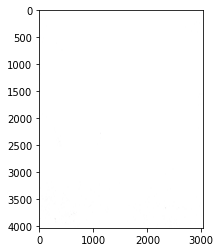

In [79]:
image_dir = './images'

img = cv2.cvtColor(cv2.imread(image_dir + '/3.png'),cv2.COLOR_BGR2RGB)
out = np.uint8(cp.asnumpy(snow_cupy(img ,3)))

plt.imshow(out)

In [11]:
start = time.time()
for i in range(100):
    img = np.zeros((512,512,3), cp.uint8) + 255
    out = np.uint8(cp.asnumpy(zoom_blur_cupy(img ,3)))
    cp.cuda.Stream.null.synchronize()
end = time.time()
print("Time elapsed:", end - start, "sec")

KeyboardInterrupt: 

In [ ]:
aug = Clouds()